In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Data Collection

In [17]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv


In [18]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [19]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [20]:
data = pd.concat([df_train, df_test], axis=0)

In [21]:
df_train.shape

(1909, 16)

In [22]:
df_test.shape

(365, 15)

In [23]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [24]:
data

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 0 to 364
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2274 non-null   object 
 1   weather_condition          2246 non-null   object 
 2   humidity                   2165 non-null   float64
 3   wind_speed                 2167 non-null   object 
 4   oil_brent_price_indicator  2274 non-null   object 
 5   temperature_station1       1930 non-null   float64
 6   temperature_station2       1946 non-null   float64
 7   temperature_station3       1934 non-null   float64
 8   temperature_station4       1954 non-null   float64
 9   temperature_station5       1937 non-null   float64
 10  temperature_station6       1953 non-null   float64
 11  temperature_station7       1913 non-null   float64
 12  temperature_station8       1938 non-null   float64
 13  temperature_station9       1924 non-null   float64
 14

In [26]:
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

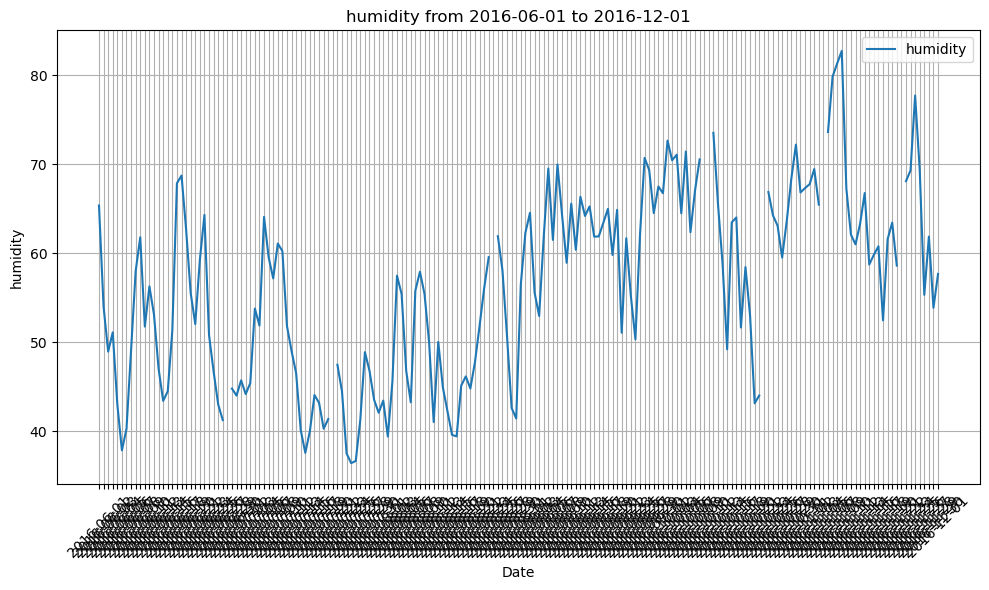

In [27]:
plot_feature_over_time(data, 'humidity', '2016-06-01', '2016-12-01')

### Data Preprocessing Evaluation Strategy

In [28]:
# Provide a complete data preprocessing transformations

#### 1. Handle Inconsistencies

In [29]:
data.sample(10)

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
1,2019-01-02,Snowy,70.869436,1.30 m/s,Moderate,1.764737,1.883483,1.791074,1.345804,2.136792,NaN,NaN,1.628191,1.873431,1.329898,NaN
37,2015-02-13,Rainy,79.156766,6.32 km/h,Very High,-0.677857,0.082145,NaN,-0.884226,-0.350698,-0.503347,-0.713665,-0.931861,-0.963772,-0.165159,312.153350
1319,2018-06-24,Sunny,NaN,16.76 km/h,Very Low,25.605456,25.619005,24.070853,NaN,25.040091,25.769837,26.505582,25.283716,26.088769,25.428574,160.835142
14,2019-01-15,Rainy,64.526934,10.24 km/h,Moderate,-2.371180,-2.302567,-3.099438,-2.572713,-2.090369,-2.462904,-2.031212,-2.432594,-2.098250,NaN,NaN
262,2019-09-20,Sunny,64.405407,18.29 km/h,Moderate,14.197344,13.444861,13.418588,14.539403,14.295846,14.006430,14.117553,13.996536,13.533197,14.425413,NaN
253,2019-09-11,Cloudy,73.504743,2.32 m/s,Moderate,6.332177,6.325492,6.124986,5.723552,NaN,6.854131,6.581665,6.649898,6.130510,6.140466,NaN
1448,2018-10-21,Sunny,56.623073,1.07 m/s,High,5.346442,5.675672,4.985956,5.215039,NaN,5.879848,5.499581,5.901053,4.744367,5.231451,232.412502
854,2017-04-05,Rainy,69.727333,2.04 m/s,High,NaN,9.849894,10.384498,10.453626,11.280230,10.487471,10.788453,11.588998,10.523804,10.246523,194.652075
1172,2018-01-31,Rainy,73.004707,4.26 m/s,High,-0.556147,-1.465353,NaN,-0.603162,-1.303449,-0.339942,-0.557719,-0.982687,-0.237677,NaN,305.424179
1897,2019-12-21,Cloudy,60.892982,18.56 km/h,Low,NaN,-4.729213,-4.703803,-4.809275,-4.145815,-5.041369,-4.423933,-4.576506,-4.427869,NaN,290.861316


In [30]:
data.info()
#date is non-null and in right form.

<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 0 to 364
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2274 non-null   object 
 1   weather_condition          2246 non-null   object 
 2   humidity                   2165 non-null   float64
 3   wind_speed                 2167 non-null   object 
 4   oil_brent_price_indicator  2274 non-null   object 
 5   temperature_station1       1930 non-null   float64
 6   temperature_station2       1946 non-null   float64
 7   temperature_station3       1934 non-null   float64
 8   temperature_station4       1954 non-null   float64
 9   temperature_station5       1937 non-null   float64
 10  temperature_station6       1953 non-null   float64
 11  temperature_station7       1913 non-null   float64
 12  temperature_station8       1938 non-null   float64
 13  temperature_station9       1924 non-null   float64
 14

In [31]:
data['weather_condition'].unique()

array(['Cloudy', 'Sunny', 'Rainy', 'Snowy', nan], dtype=object)

In [32]:
data['oil_brent_price_indicator'].unique()

array(['Moderate', 'High', 'Low', 'Very Low', 'Very High'], dtype=object)

We need transform categorical features in to numbers.

In [33]:
weather_to_num={'Snowy':0,'Rainy':1,'Cloudy':2,'Sunny':3}
oil_indicator_to_num={'Very Low':0,'Low':1,'Moderate':2,'High':3,'Very High':4}

def transfer_categorical(X):
    X_new=X.copy()
    X_new['weather_condition']=X['weather_condition'].map(lambda x: weather_to_num.get(x, x))
    X_new['oil_brent_price_indicator']=X['oil_brent_price_indicator'].map(lambda x: oil_indicator_to_num.get(x, x))
    return X_new

In [34]:
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

We need to handle the *wind_speed* in same measure.

In [35]:
def transfer_speed(X):
    def regularize_speed(s=None):
        if isinstance(s,list):
            if(s[1]=='km/h'):
                return float(s[0])*(5/18)
            else:
                return float(s[0])
        else:
            return None
    X_new=X.copy()
    X_new["wind_speed"]=X["wind_speed"].str.split().apply(regularize_speed)
    return X_new


In [36]:
transfer_categorical(transfer_speed(data)).info()

<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 0 to 364
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2274 non-null   object 
 1   weather_condition          2246 non-null   float64
 2   humidity                   2165 non-null   float64
 3   wind_speed                 2167 non-null   float64
 4   oil_brent_price_indicator  2274 non-null   int64  
 5   temperature_station1       1930 non-null   float64
 6   temperature_station2       1946 non-null   float64
 7   temperature_station3       1934 non-null   float64
 8   temperature_station4       1954 non-null   float64
 9   temperature_station5       1937 non-null   float64
 10  temperature_station6       1953 non-null   float64
 11  temperature_station7       1913 non-null   float64
 12  temperature_station8       1938 non-null   float64
 13  temperature_station9       1924 non-null   float64
 14

#### 2. Handle Duplicates

In [37]:
data[data.duplicated()]

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
6,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
52,2015-02-27,Snowy,61.321278,11.61 km/h,Moderate,-0.765329,-1.089098,-0.272114,-1.010996,-1.117890,-0.483191,-1.151202,-0.835624,NaN,NaN,315.651282
59,2015-03-05,Cloudy,54.187891,1.02 m/s,Very Low,11.442087,12.320326,10.781174,10.926194,11.684710,11.934129,11.126555,11.184591,12.166137,11.424691,227.826146
129,2015-05-13,Rainy,73.325559,0.00 m/s,Low,18.498219,NaN,18.759225,17.965813,18.194051,18.985841,NaN,18.107817,17.608444,18.213252,158.980858
141,2015-05-24,Cloudy,62.308585,9.01 km/h,High,15.276012,16.229540,15.573580,NaN,14.924697,15.358168,16.625796,14.942922,15.245391,14.972707,181.950367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,2019-10-26,Sunny,53.952131,4.30 m/s,Moderate,8.270356,7.883475,7.625069,7.440476,7.912821,7.977848,8.660085,8.713239,7.738383,7.727704,204.628575
1875,2019-12-01,Snowy,72.532746,3.99 m/s,Moderate,12.758419,12.751674,12.517225,13.536174,12.175204,13.163137,12.795622,12.909812,12.308309,13.685464,186.026715
1886,2019-12-11,NaN,61.201308,27.61 km/h,Moderate,0.743648,1.006100,NaN,0.593362,0.851021,0.336086,0.934330,NaN,NaN,0.879479,301.559770
1893,2019-12-17,Snowy,65.362283,5.21 m/s,Moderate,-2.380559,-2.727055,-2.769237,NaN,-1.560074,-2.888126,NaN,NaN,-2.474213,-2.380799,290.157907


#### 3. Handle Missing Values

In [40]:
df_train[df_train.isna().any(axis=1)]

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
5,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2019-12-26,Snowy,NaN,23.86 km/h,Moderate,0.591722,0.203106,NaN,-0.722352,0.494092,0.323693,0.058856,0.573923,1.723748,0.471477,330.970576
1904,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,254.061886
1905,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,266.231273
1906,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,266.231273


In [41]:
df_test[df_test.isna().any(axis=1)]

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10
0,2019-01-01,Rainy,72.985535,5.83 km/h,High,NaN,2.041746,1.992639,2.821712,1.636189,2.795024,1.674621,2.832348,2.058945,2.022864
1,2019-01-02,Snowy,70.869436,1.30 m/s,Moderate,1.764737,1.883483,1.791074,1.345804,2.136792,NaN,NaN,1.628191,1.873431,1.329898
2,2019-01-03,Cloudy,64.788216,0.21 m/s,Moderate,3.577973,3.311595,3.873189,3.324726,3.620829,3.380151,3.277014,3.370558,NaN,3.302191
3,2019-01-04,Cloudy,63.144525,0.00 m/s,High,3.098592,2.863002,3.308336,NaN,3.124391,3.385149,2.976644,2.638640,3.079406,3.062108
5,2019-01-06,Rainy,75.670052,5.36 km/h,Moderate,-0.878220,-1.609823,-0.982804,-0.607022,-0.487977,-0.865485,-0.576630,-0.753451,-1.235199,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2019-12-25,Rainy,72.533215,7.24 m/s,Moderate,0.319429,-0.856147,0.085822,NaN,0.044269,-0.034963,1.027483,0.324912,0.067675,0.242769
359,2019-12-26,Snowy,NaN,23.86 km/h,Moderate,0.591722,0.203106,NaN,-0.722352,0.494092,0.323693,0.058856,0.573923,1.723748,0.471477
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333


Number of missing values per column of train data:
date                           0
weather_condition             24
humidity                      96
wind_speed                    90
oil_brent_price_indicator      0
temperature_station1         285
temperature_station2         275
temperature_station3         289
temperature_station4         277
temperature_station5         279
temperature_station6         273
temperature_station7         308
temperature_station8         282
temperature_station9         288
temperature_station10        316
electricity_demand             0
dtype: int64


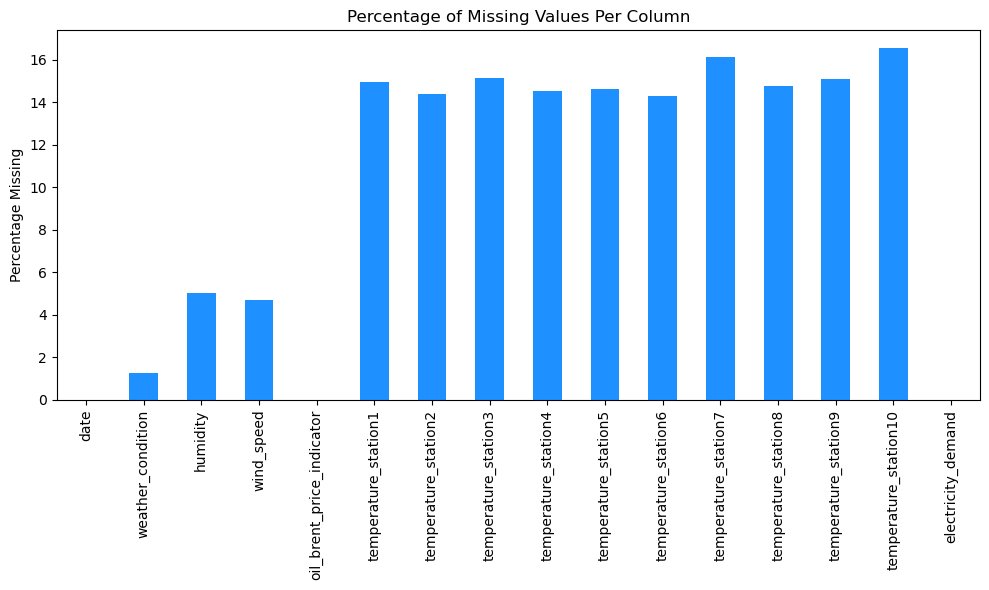

In [42]:
print("Number of missing values per column of train data:")
missing_data=df_train.isna().sum()
print(missing_data)
percent_missing = df_train.isnull().mean() * 100
plt.figure(figsize=(10, 6))
percent_missing.plot(kind='bar', color='dodgerblue')
plt.title('Percentage of Missing Values Per Column')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Number of missing values per column of test data:
date                          0
weather_condition             4
humidity                     13
wind_speed                   17
oil_brent_price_indicator     0
temperature_station1         59
temperature_station2         53
temperature_station3         51
temperature_station4         43
temperature_station5         58
temperature_station6         48
temperature_station7         53
temperature_station8         54
temperature_station9         62
temperature_station10        51
dtype: int64


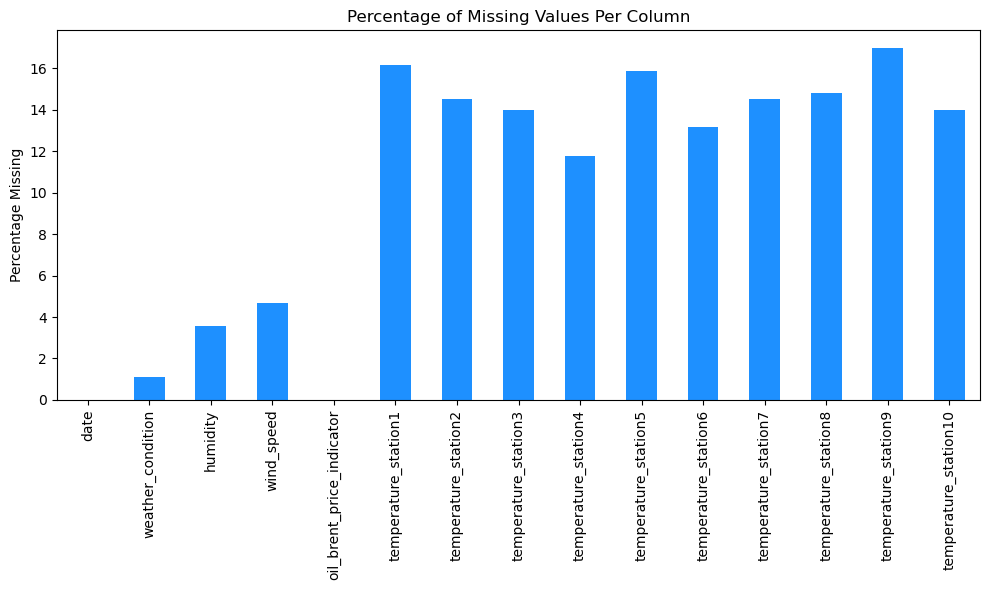

In [43]:
print("Number of missing values per column of test data:")
missing_data=df_test.isna().sum()
print(missing_data)
percent_missing = df_test.isnull().mean() * 100
plt.figure(figsize=(10, 6))
percent_missing.plot(kind='bar', color='dodgerblue')
plt.title('Percentage of Missing Values Per Column')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

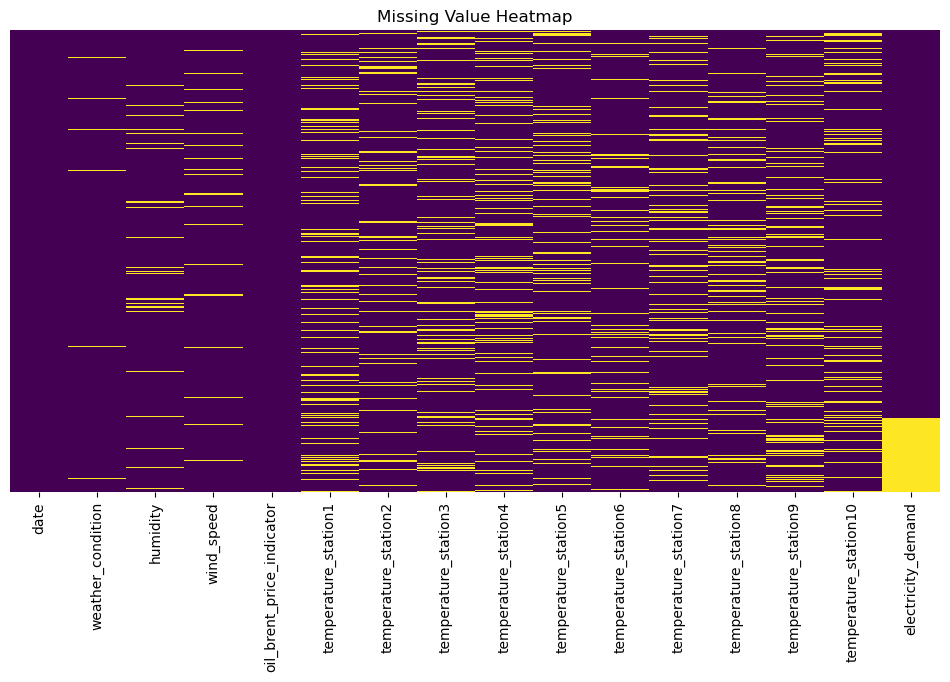

In [44]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.show()

Correlation between temperature station


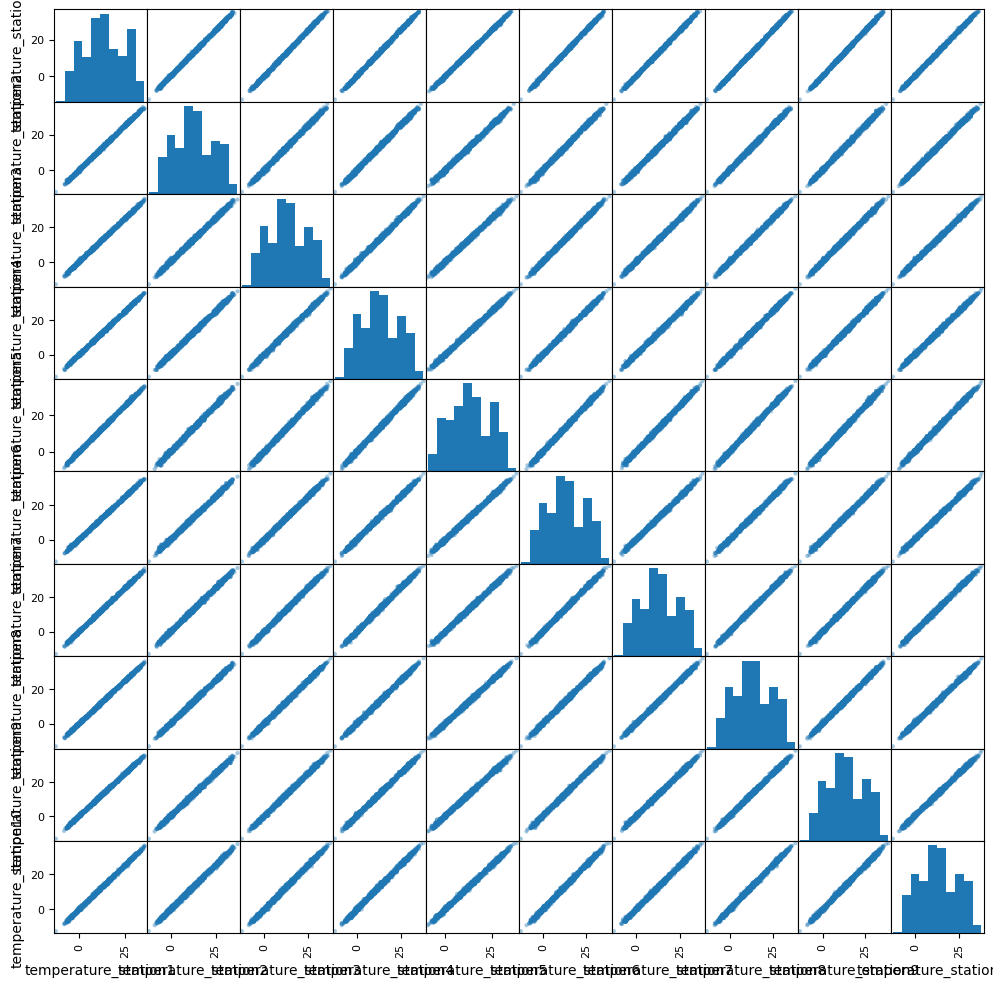

In [45]:
from pandas.plotting import scatter_matrix
print("Correlation between temperature station")
scatter_matrix(data.iloc[:,4:15],figsize=(12,12),alpha=0.4)
plt.show()

Each row has at least one temperature value.

In [46]:
data.iloc[:,1:]

,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [47]:
def fill_temperatures(X):
    X_filled=X.copy()
    for i in range(len(X)):
        if X.iloc[i,5:15].isna().any():
            X_filled.iloc[i,5:15]=X.iloc[i,5:15].fillna(np.mean(X.iloc[i,5:15]))
    return X_filled
def fill_other_features(X):
    X_filled=X.copy()
    imputer=KNNImputer(n_neighbors=1)
    X_filled.iloc[:,1:]=imputer.fit_transform(X.iloc[:,1:])
    return X_filled

#### Handle Outliers

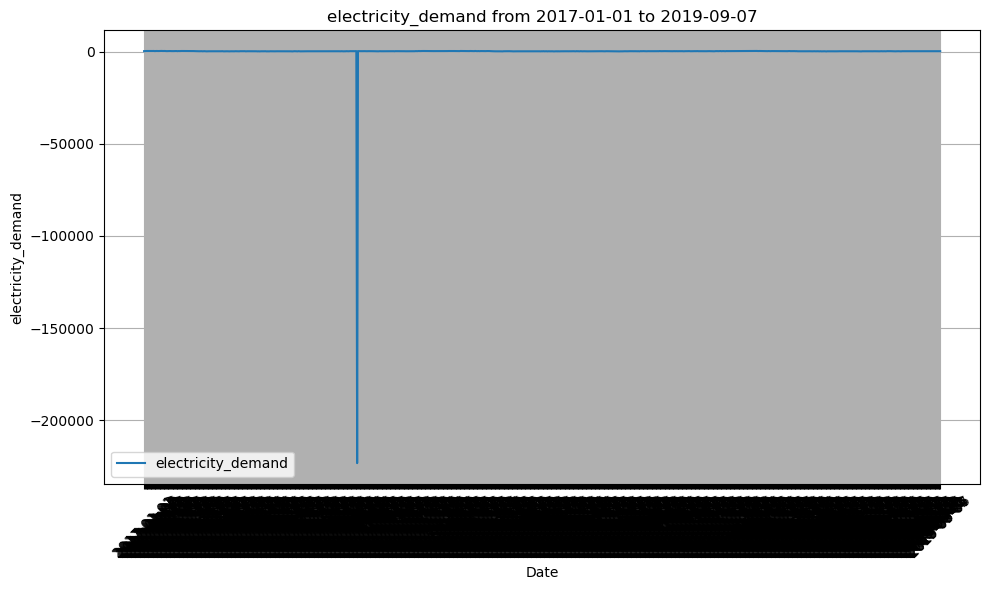

In [66]:
plot_feature_over_time(data, 'electricity_demand', '2017-01-01', '2019-09-07')

#### Preprocess Procedure

In [58]:
# 1. Handle Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    def transfer_speed(X):
        def regularize_speed(s=None):
            if isinstance(s,list):
                if(s[1]=='km/h'):
                    return float(s[0])*(5/18)
                else:
                    return float(s[0])
            else:
                return None
        X_new=X.copy()
        X_new["wind_speed"]=X["wind_speed"].str.split().apply(regularize_speed)
        return X_new
    weather_to_num={'Snowy':0,'Rainy':1,'Cloudy':2,'Sunny':3}
    oil_indicator_to_num={'Very Low':0,'Low':1,'Moderate':2,'High':3,'Very High':4}
    def transfer_categorical(X):
        X_new=X.copy()
        X_new['weather_condition']=X['weather_condition'].map(lambda x: weather_to_num.get(x, x))
        X_new['oil_brent_price_indicator']=X['oil_brent_price_indicator'].map(lambda x: oil_indicator_to_num.get(x, x))
        return X_new
    if X_val is not None:
        X_train_new=transfer_speed(X_train)
        X_val_new=transfer_speed(X_val)
        X_train_new=transfer_categorical(X_train_new)
        X_val_new=transfer_categorical(X_val_new)
        return X_train_new, y_train.copy(), X_val_new
    else:
        X_train_new=transfer_speed(X_train)
        X_train_new=transfer_categorical(X_train_new)
        return X_train_new, y_train.copy()
# 2. Handling Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    if X_val is not None:
        X_train_no_duplicates = X_train.drop_duplicates()
        y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]
        return X_train_no_duplicates, y_train_no_duplicates, X_val.drop_duplicates()
    else:
        X_train_no_duplicates = X_train.drop_duplicates()
        y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]
        return X_train_no_duplicates, y_train_no_duplicates

# 3. Handling Missing Values
def handle_missing_values(X_train, y_train, X_val=None):
    def fill_temperatures(X):
        X_filled=X.copy()
        for i in range(len(X)):
            if X.iloc[i,5:15].isna().any():
                X_filled.iloc[i,5:15]=X.iloc[i,5:15].fillna(np.mean(X.iloc[i,5:15]))
        return X_filled
    def fill_other_features(X):
        X_filled=X.copy()
        imputer=KNNImputer(n_neighbors=1)
        X_filled.iloc[:,1:]=imputer.fit_transform(X.iloc[:,1:])
        return X_filled
    if X_val is not None:
        X_train_filled=fill_temperatures(X_train)
        X_val_filled = fill_temperatures(X_val)
        X_train_filled=fill_other_features(X_train_filled)
        X_val_filled=fill_other_features(X_val_filled)
        return X_train_filled, X_val_filled
    else:
        X_train_filled=fill_temperatures(X_train)
        X_train_filled=fill_other_features(X_train_filled)
        return X_train_filled

# 4. Handling Categorical Values
def handle_categorical(X_train, y_train, X_val=None):
    if X_val is not None:
        return X_train.copy(), X_val.copy()
    else:
        return X_train.copy()

# 5. Handling Outliers
def handle_outliers(X_train, y_train, X_val=None):
    def find_outliers_iqr(new_data, threshold=1.5):
        q1 = np.percentile(new_data, 25)
        q3 = np.percentile(new_data, 75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        res = np.where((new_data < lower_bound) | (new_data > upper_bound))[0]
        return res
    res=np.array([])
    selected_columns = ['humidity', 'wind_speed', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10']
    for col in selected_columns:
        res=np.append(res,find_outliers_iqr(X_train[col]))
    res=np.unique(np.append(res,find_outliers_iqr(y_train)))
    if X_val is not None:
        return X_train.drop(X_train.iloc[res].index), y_train.drop(X_train.iloc[res].index), X_val.copy()
    else:
        return X_train.drop(X_train.iloc[res].index), y_train.drop(X_train.iloc[res].index)

# 6. Feature Engineering
def feature_engineering(X_train, y_train, X_val=None):
    def add_time_features(data):
        new_data=data.copy()
        new_data['date'] = pd.to_datetime(data['date'])
        new_data['dayofyear'] = new_data['date'].dt.dayofyear
        new_data['month'] = new_data['date'].dt.month
        new_data['day'] = new_data['date'].dt.day
        new_data['hour'] = new_data['date'].dt.hour
        new_data['dayofweek'] = new_data['date'].dt.dayofweek
        new_data['is_weekend'] = new_data['dayofweek'].isin([5, 6]).astype(int)
        new_data['week_of_year'] = new_data['date'].dt.isocalendar().week
        new_data['month_progress'] = new_data['date'].dt.day / new_data['date'].dt.days_in_month
        return new_data	
    def add_aggregate_features(data):
        new_data=data.copy()
        new_data['avg_temp']=data[['temperature_station1','temperature_station2',
                        'temperature_station3', 'temperature_station4',
                        'temperature_station5', 'temperature_station6',
                        'temperature_station7','temperature_station8', 
                        'temperature_station9', 'temperature_station10']].mean(axis=1)
        #for lag in [1, 2]:
        #    new_data[f'avg_temp_lag_{lag}'] = new_data['avg_temp'].shift(lag)
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(new_data[['avg_temp', 'humidity']])
        poly_feature_names = poly.get_feature_names_out(['avg_temp', 'humidity'])
        new_data[poly_feature_names] = poly_features
        new_data['log_windspeed'] = np.log1p(data['wind_speed'])
        return new_data 
    X_train_new=X_train.copy()
    X_train_new=add_time_features(X_train_new)
    X_train_new=add_aggregate_features(X_train_new)
    if X_val is not None: 
        X_val_new=X_val.copy()
        X_val_new=add_time_features(X_val_new)
        X_val_new=add_aggregate_features(X_val_new)
        return X_train_new, y_train, X_val_new
    else:
        return X_train_new, y_train

# 7. Feature Selection and Dimensionality Reduction
def feature_selection(X_train, y_train, X_val=None):
    selected_columns = ['humidity','weather_condition', 'wind_speed','oil_brent_price_indicator',
                        'temperature_station1','temperature_station2',
                        'temperature_station3', 'temperature_station4',
                        'temperature_station5', 'temperature_station6',
                        'temperature_station7','temperature_station8', 
                        'temperature_station9', 'temperature_station10',
                        'dayofyear', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',
                        'week_of_year', 'month_progress', 'avg_temp', 'avg_temp^2',
                        'avg_temp humidity', 'humidity^2', 'log_windspeed']
    if X_val is not None:
        return X_train[selected_columns], X_val[selected_columns]
    else:
        return X_train[selected_columns]

In [59]:
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    X, y = handle_duplicates(X, y)
    X  = handle_missing_values(X, y)
    X_train = handle_categorical(X, y)
    X, y = handle_outliers(X, y)
    X, y = feature_engineering(X, y)
    X = feature_selection(X, y)
    
    #model = LinearRegression()
    model= XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        ### call transformations here, if there is learning
        # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        #X_train, X_val = handle_categorical(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        #X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

In [60]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 0.0010, Validation MSE: 509.1360
Processing fold 2/5...
Fold 2 Train MSE: 0.0844, Validation MSE: 421.7025
Processing fold 3/5...
Fold 3 Train MSE: 0.6873, Validation MSE: 449.1759
Processing fold 4/5...
Fold 4 Train MSE: 2.0412, Validation MSE: 396.7111
Processing fold 5/5...
Fold 5 Train MSE: 4.8095, Validation MSE: 387.6371

Train MSE:
Mean: 1.5247, Max: 4.8095, Min: 0.0010

Validation MSE:
Mean: 432.8725, Max: 509.1360, Min: 387.6371


432.87251376353817

### Generating Submission File

In [61]:
# Train and submit your results

In [62]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [63]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    #model = LinearRegression()
    model=XGBRegressor()

    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [64]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1810, 27)
Predicting on test dataset of shape: (365, 27)


In [65]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date'],
    'electricity_demand': y_test_pred})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
